In [1]:
!curl "https://storage.googleapis.com/kaggle-datasets/87153/200743/cell-images-for-detecting-malaria.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1562958671&Signature=mT1HkWDHcdWwL7kzboZNGHB"%"2BTmdo517HuuqnGeNNevps1Z0915"%"2BUJ1StQtE"%"2BN4ityz1Q7IkYFj9sxwXkaH"%"2F6I9"%"2FHGBz8Db60dWjqp0V"%"2BZD6CzANHA0DSPcpvmTfWWfmPAFfuAVJCzq5oImeb9SAXudgcnDnBQmZaqR1fHkRXpAgcx1uxXEB5d8X2ddQuJe4m614rde13FVMkiFyYsM6miZrEP6y87XeV1bFWi"%"2FZ3zEv4wYbdmKc"%"2FcCq2uyp"%"2BP0MVfQCJq48UqksPMT6cqg836ioLsiRLJS4GEGgAU"%"2FOsg36caT6uAOzggGLaznP7MnPXiGCrvkpl8TrpzOMad9MhOQ"%"3D"%"3D" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:67.0) Gecko/20100101 Firefox/67.0" -H "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8" -H "Accept-Language: en-US,en;q=0.5" --compressed -H "DNT: 1" -H "Connection: keep-alive" -H "Upgrade-Insecure-Requests: 1" -o output

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  337M  100  337M    0     0  29.3M      0  0:00:11  0:00:11 --:--:-- 37.1M


Data donwload with curl command

In [ ]:
!unzip output.zip

lets unzip the data

 now lets rename import the required packages

In [3]:
from fastai import *
from fastai.vision import *
from fastai.imports import *
import numpy as np
import pandas as pd


In [4]:
!pip install split_folders

In [5]:
import split_folders

In [7]:
split_folders.ratio('cell_images',output = 'dataset',seed = 1434,ratio = (.7,.2,.1))

we have split our dataset with train,val and test folders]

now we will create our image databunch

In [8]:
tfms = get_transforms(do_flip=True,max_warp=0.1)

In [9]:
src = (ImageList.from_folder('dataset').split_by_folder().label_from_folder().add_test_folder())

In [10]:
data = (src.transform(tfms,size = 68).databunch()).normalize(imagenet_stats)

In [11]:
data.c

2

In [12]:
data.classes

['Parasitized', 'Uninfected']

In [13]:
#lets define the learner for this dataset
learn  = cnn_learner(data,models.resnet34,metrics = [error_rate])

/usr/local/lib/python3.6/dist-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 100322101.13it/s]


In [14]:
# we have loaded the pretrained weights of model resnet34 achitecturea
# and we will use it for transfer learning

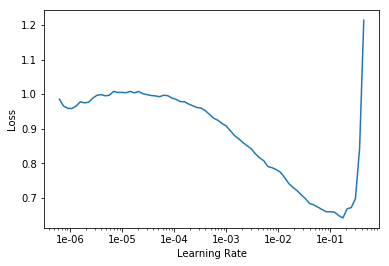

In [16]:
#lets find out a good learning rate to train our model
#learn.lr_find()
learn.recorder.plot()

In [17]:
#lets plot the losses
# from avove find the steepest path from left
lr = 1e-03

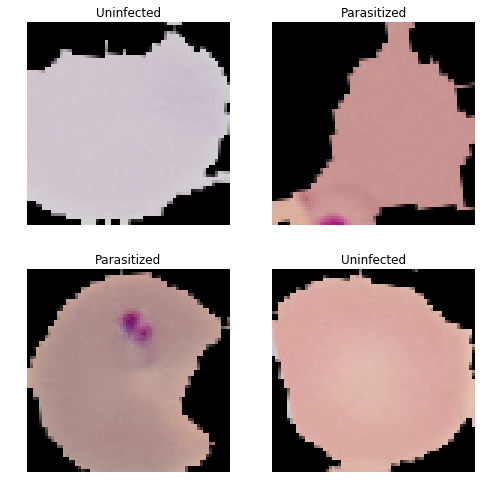

In [18]:
#lets train with 4 epochs and see the result
data.show_batch(2,figsize = (7,7))

In [19]:
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.362008,0.268989,0.107039,01:17
1,0.251070,0.207556,0.074927,01:16
2,0.206270,0.185277,0.068033,01:16
3,0.210461,0.182128,0.066945,01:17


In [20]:
#lets use the image with increased pixel values

as we can see our model got 93.5% accurate on the first go
lets now unfreezer the model and then train the whole model on our dataset from scratch

In [21]:
#first find a good learner rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


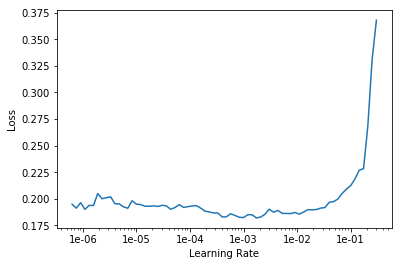

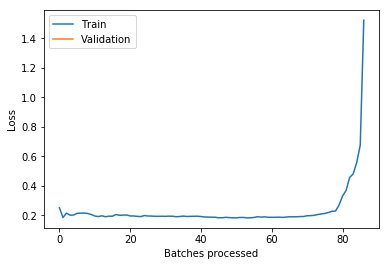

In [22]:
learn.recorder.plot()
learn.recorder.plot_losses()

In [23]:
learn.save('stage1_with_93%')

In [24]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(5,max_lr =slice(1e-04,lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.178437,0.156709,0.057148,01:21
1,0.162489,0.121272,0.042271,01:22
2,0.127426,0.124878,0.046081,01:23
3,0.104479,0.102229,0.037736,01:22
4,0.092442,0.099519,0.037736,01:21


In [27]:
#lets see if we can improve the previous result that we got from the prev 
#result

so now our model goes up to approx 96.3% which is great in the first go 
lets save our model and explore more on the results insights

In [28]:
learn.save('96.3%accurate_stage2')

In [29]:
# but i think i can improve more in this model 
# we will do that and push our model upto 98%
# accurate believe me/

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

In [31]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 116), ('Uninfected', 'Parasitized', 92)]

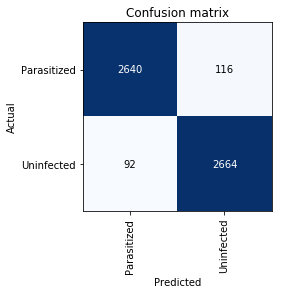

In [32]:
interp.plot_confusion_matrix()

the above confusion matrix tell us that we have misclassified paraseitized 116 times and Uninfected 92 times 
we need to boost our performance with our new
trick on the sleeves

In [33]:
#lets use the trick
#lets increase the image size that we have decreased in
#the first go

In [34]:
#we are replacing our data with new 136x136 original pixel sized image
#that we have decreased into 68x68

In [35]:
#this is where we will rock
data = (src.transform(tfms,size = 136).databunch()).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


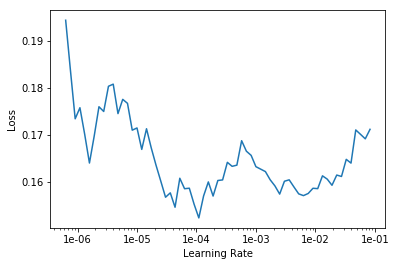

In [38]:
# now we will replace our learner data with new data that we hace created
learn.data = data 
#and we will again freezer our resnet architecture to test
#how it is doing on the pretrained weights
learn.freeze()
#again we will find our learner rate
learn.lr_find()
#plot the learner rate finder graph
learn.recorder.plot()

In [ ]:
learn.load('96.3%accurate_stage2')

In [39]:
new_lr = 3e-05

In [40]:
learn.fit_one_cycle(4,slice(new_lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.168036,0.164020,0.053338,01:56
1,0.165696,0.147256,0.051705,01:56
2,0.147723,0.138712,0.049710,01:57
3,0.154506,0.142084,0.051161,01:57


In [41]:
# lets now unfreeze it
learn.save('high_pixel_stage1_95%')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


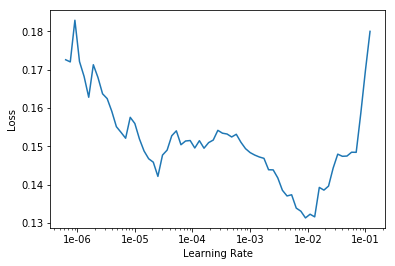

In [42]:
learn.lr_find()
learn.recorder.plot()

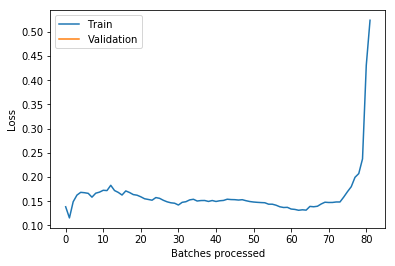

In [43]:
learn.recorder.plot_losses()

In [44]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(6,slice(7e-04,new_lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,0.126653,0.129550,0.046626,02:08
1,0.128580,0.121948,0.044267,02:09
2,0.118949,0.114820,0.042271,02:09
3,0.107361,0.108291,0.040094,02:08
4,0.087794,0.098681,0.035922,02:08
5,0.076390,0.091558,0.033563,02:08


In [ ]:
# lets see how well this this it performs

In [ ]:
'string'

In [48]:
'string'

'string'

In [49]:
learn.save('new_record_96.7%stage2_part2')

In [50]:
learn.export()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


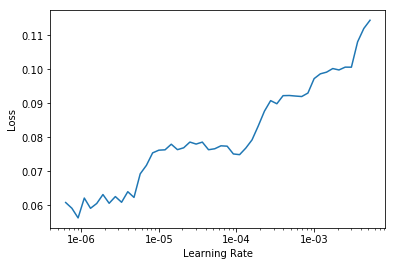

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4,slice(7e-06,7e-04/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.076605,0.095193,0.035740,02:08
1,0.072909,0.095610,0.034289,02:09
2,0.070248,0.093329,0.034289,02:08
3,0.064981,0.093526,0.033019,02:08


In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


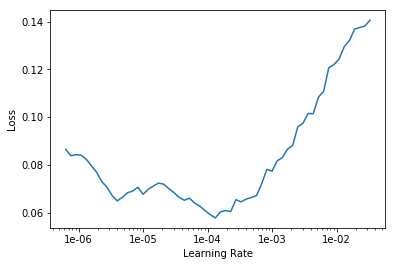

In [56]:
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(7,slice(3.3e-05,7e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.079498,0.101416,0.037373,02:08
1,0.104951,0.102173,0.037736,02:08
2,0.104451,0.093997,0.033563,02:08
3,0.080633,0.098240,0.034833,02:08
4,0.070951,0.095941,0.036466,02:08
5,0.054162,0.090525,0.031567,02:08
6,0.055595,0.094588,0.032837,02:08


In [58]:
learn.save('96.9%')

In [59]:
# I think this is good and with more tuning we can get upto 98 percent accuracy 

In [60]:
interp = ClassificationInterpretation.from_learner(learn)

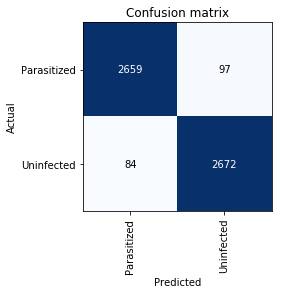

In [61]:
interp.plot_confusion_matrix()

In [62]:
interp.most_confused()

[('Parasitized', 'Uninfected', 97), ('Uninfected', 'Parasitized', 84)]

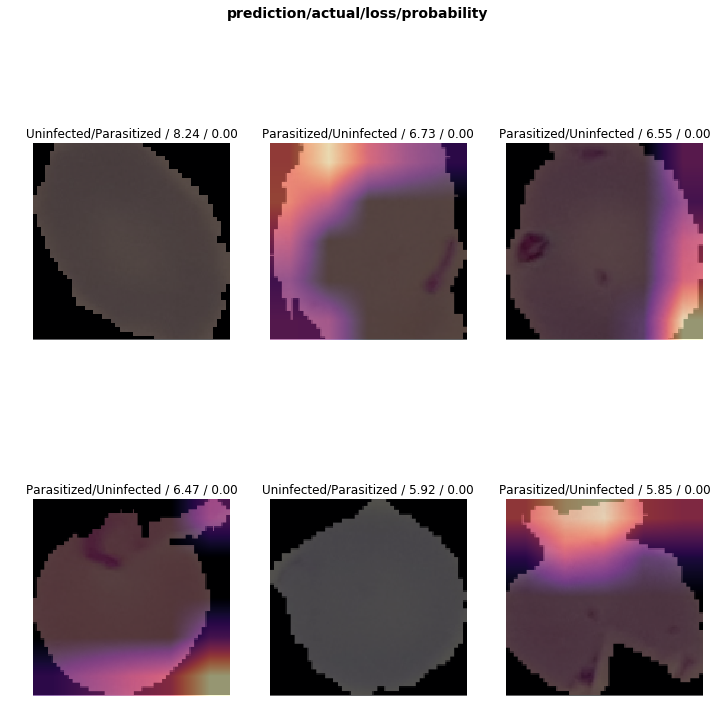

In [66]:
interp.plot_top_losses(k=6)

In [68]:
interp.preds

tensor([[2.4677e-03, 9.9753e-01],
        [7.9158e-05, 9.9992e-01],
        [1.4610e-02, 9.8539e-01],
        ...,
        [9.9321e-01, 6.7910e-03],
        [9.9188e-01, 8.1231e-03],
        [9.9972e-01, 2.7593e-04]])

In [ ]:
# so yeah you can use this as a reference if u want explore about this 
#dataset more adnwho